In [4]:
pip install praw pandas vaderSentiment nltk seaborn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [5]:
import praw

# Initialize Reddit API
reddit = praw.Reddit(
    client_id='nfFxVfZmVRfNAE4rg_UJwg',         # Replace with your credentials
    client_secret='bovC1F39IZujHdrtY6is7QInHtSWCA',
    user_agent='AI_Ethics_Sentiment_Scraper'
)


In [6]:
import pandas as pd
import time

subreddits = [
    'technology', 'MachineLearning', 'artificial', 'futurology',
    'ethics', 'datascience', 'finance', 'economics',
    'policy', 'privacy', 'cscareerquestions', 'bias', 'algorithms'
]

search_query = '("AI" OR "artificial intelligence") AND (ethics OR bias OR fairness OR discrimination OR transparency OR privacy OR autonomy OR "human oversight") AND (governance OR "credit scoring" OR "algorithmic decision-making" OR hiring OR finance OR economics)'
limit_per_subreddit = 200  # You can increase this if needed

posts = []
comments = []

for sub in subreddits:
    print(f"Searching in r/{sub}")
    try:
        for post in reddit.subreddit(sub).search(search_query, sort='new', time_filter='year', limit=limit_per_subreddit):
            posts.append({
                'type': 'post',
                'id': post.id,
                'subreddit': sub,
                'title': post.title,
                'body': post.selftext,
                'score': post.score,
                'created_utc': post.created_utc
            })

            try:
                post.comments.replace_more(limit=0)
                # Sort comments by score
                sorted_comments = sorted(
                    post.comments.list(),
                    key=lambda x: x.score if hasattr(x, 'score') else 0,
                    reverse=True
                )
                # Add top 10 comments
                for comment in sorted_comments[:10]:
                    comments.append({
                        'type': 'comment',
                        'id': comment.id,
                        'subreddit': sub,
                        'title': post.title,
                        'body': comment.body,
                        'score': comment.score,
                        'created_utc': comment.created_utc
                    })
            except Exception as e:
                print(f"Skipping comments for {post.id}: {e}")

            time.sleep(1)  # Be respectful to Reddit API
    except Exception as e:
        print(f"Skipping subreddit {sub} due to error: {e}")

print(f"✅ Collected {len(posts)} posts and {len(comments)} comments")




Searching in r/technology
Searching in r/MachineLearning
Searching in r/artificial
Searching in r/futurology
Searching in r/ethics
Searching in r/datascience
Searching in r/finance
Searching in r/economics
Searching in r/policy
Searching in r/privacy
Searching in r/cscareerquestions
Searching in r/bias
Searching in r/algorithms
✅ Collected 144 posts and 1002 comments


In [7]:
df_posts = pd.DataFrame(posts)
df_comments = pd.DataFrame(comments)
df = pd.concat([df_posts, df_comments], ignore_index=True)

df['full_text'] = (df['title'].fillna('') + ' ' + df['body'].fillna(''))
df = df[df['full_text'].str.strip() != '']  # remove empty entries

print(f"Total records after merging: {df.shape[0]}")


Total records after merging: 1146


In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned'] = df['full_text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yevag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yevag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['cleaned'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(label_sentiment)


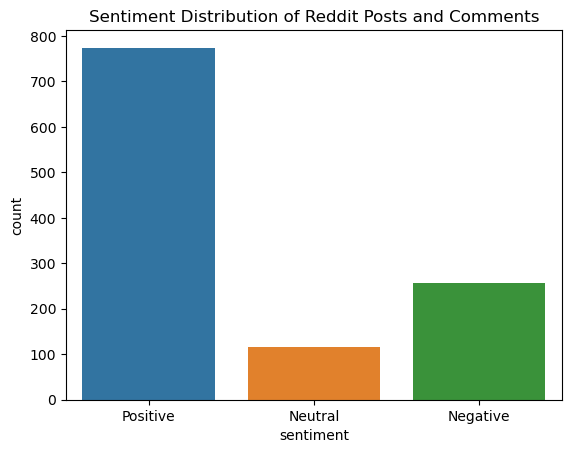

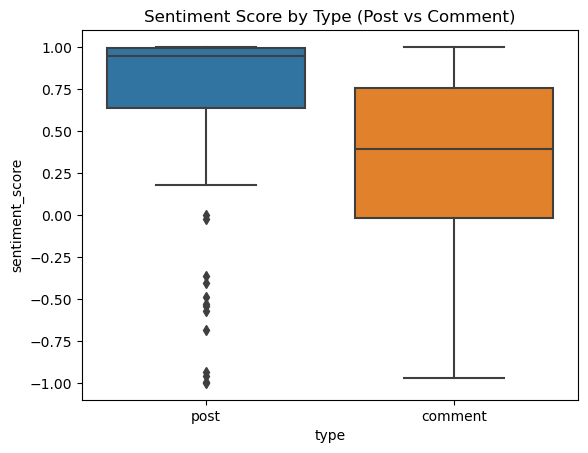

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot: Sentiment distribution
sns.countplot(data=df, x='sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title("Sentiment Distribution of Reddit Posts and Comments")
plt.show()

# Box plot: Sentiment by source
sns.boxplot(data=df, x='type', y='sentiment_score')
plt.title("Sentiment Score by Type (Post vs Comment)")
plt.show()


#Around 750+ entries are classified as Positive, making up a large majority of your dataset.
#Roughly 250+ entries are labeled Negative, showing a notable amount of concern or criticism — which is expected in ethics discussions.
#Only about 100–120 entries are Neutral, suggesting that most posts/comments contain either favorable or critical opinions rather than factual reporting or balanced discussion.
#There might be an optimistic tone when people talk about AI in finance/governance — possibly due to excitement around innovation, productivity, or opportunity.
#The Negative chunk is still substantial, possibly reflecting concerns about:algorithmic bias, lack of transparency, data misuse,fairness in credit/hiring


In [11]:
df.to_excel("reddit_ai_ethics_sentiment(comments added).xlsx", index=False)

print("Data saved to reddit_ai_ethics_sentiment.csv")


Data saved to reddit_ai_ethics_sentiment.csv


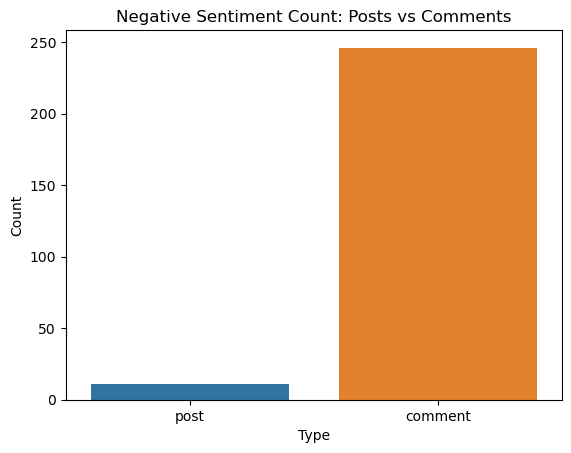

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df[df['sentiment'] == 'Negative'], x='type')
plt.title("Negative Sentiment Count: Posts vs Comments")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()


In [23]:
#starting topic modelling on negative sets
df_neg = df[df['sentiment'] == 'Negative'].copy()


In [24]:
neg_tokens = df_neg['cleaned'].apply(lambda x: x.split())


In [25]:
from gensim.corpora import Dictionary

dictionary = Dictionary(neg_tokens)
dictionary.filter_extremes(no_below=5, no_above=0.5)  # tune if needed
corpus = [dictionary.doc2bow(text) for text in neg_tokens]


In [26]:
from gensim.models.ldamodel import LdaModel

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,       # you can try 5–10 topics
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)


In [27]:
for i, topic in lda_model.print_topics():
    print(f"\nTopic {i+1}:")
    print(topic)



Topic 1:
0.052*"ai" + 0.023*"data" + 0.019*"people" + 0.014*"im" + 0.013*"work" + 0.012*"used" + 0.012*"want" + 0.011*"like" + 0.010*"openai" + 0.010*"models"

Topic 2:
0.019*"people" + 0.016*"ai" + 0.016*"identity" + 0.016*"one" + 0.016*"us" + 0.015*"dont" + 0.014*"privacy" + 0.014*"would" + 0.014*"government" + 0.012*"data"

Topic 3:
0.021*"llms" + 0.021*"going" + 0.020*"new" + 0.020*"company" + 0.019*"crash" + 0.018*"even" + 0.014*"power" + 0.013*"theres" + 0.013*"time" + 0.013*"spending"

Topic 4:
0.020*"theft" + 0.018*"models" + 0.016*"problem" + 0.015*"world" + 0.015*"one" + 0.013*"power" + 0.012*"advertising" + 0.012*"could" + 0.012*"postapocalyptic" + 0.012*"personal"

Topic 5:
0.079*"ai" + 0.018*"system" + 0.016*"could" + 0.015*"already" + 0.014*"would" + 0.014*"human" + 0.013*"future" + 0.013*"humans" + 0.012*"think" + 0.012*"need"


In [ ]:
# description of every topic:
#1. Topic 1: AI Governance, Public Concern & Government Trust
#2. Topic 2: Privacy, Identity, and Big Tech
#3. Topic 3: AI Power, Collapse Fears, and Human Risk
#4. Topic 4: Model Safety, LLMs, and OpenAI Critique
#5. Topic 5: Data Control, Personal Privacy, and Consent